In [1]:
import sys
import os

In [2]:
if 'google.colab' in sys.modules:
    os.system('apt install python3-mpi4py cython3 libxc-dev gpaw-data')
    os.system('pip install --upgrade gpaw pymatgen')

In [3]:
from ase.build import bulk
from ase.atom import Atom
from ase.atoms import Atoms
from gpaw import GPAW, PW
from ase.visualize.plot import plot_atoms
from ase.visualize import view
import numpy as np
from tqdm.auto import tqdm
from ase.eos import EquationOfState
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rc('font', size=20)
plt.rc('figure', figsize=(18,6))

otras funciones de conveniencia:

In [11]:
# NO ME ANDABA ==> def econvergence(E: list[float]):
def econvergence(E: list):
    return np.abs((E[:-1] - E[-1])/E[-1])

def load_calc(filename, **kwargs):
    if os.path.exists(filename):
        calc = GPAW(filename)
    else:
        calc = GPAW(**kwargs)
    return calc
        

# Generamos la estructura

la función [ase.build.bulk](https://wiki.fysik.dtu.dk/ase/ase/build/build.html?highlight=build) genera estructuras bulk, los argumentos son la composición química, la estructura cristalina, el parámetro de red y si se quiere una celda convencional o primitiva. El Output es un [objeto atoms](https://wiki.fysik.dtu.dk/ase/ase/atoms.html#ase.Atoms), que permitirá luego manipular sus componentes. Se puede pensar el estos objetos como listas de [objetos Atom](https://wiki.fysik.dtu.dk/ase/ase/atom.html#ase.atom.Atom), de átomos individuales

**Generamos la estructura de equilibrio del Si**, que es cúbica diamante.

In [12]:
SiDiamond = bulk('Si', 'diamond', a=4., cubic=True)

In [13]:
printatoms = [print(at) for at in SiDiamond]

Atom('Si', [0.0, 0.0, 0.0], index=0)
Atom('Si', [1.0, 1.0, 1.0], index=1)
Atom('Si', [0.0, 2.0, 2.0], index=2)
Atom('Si', [1.0, 3.0, 3.0], index=3)
Atom('Si', [2.0, 0.0, 2.0], index=4)
Atom('Si', [3.0, 1.0, 3.0], index=5)
Atom('Si', [2.0, 2.0, 0.0], index=6)
Atom('Si', [3.0, 3.0, 1.0], index=7)


In [14]:
SiDiamond[0] # te da el simbolo y la posición  del primer atomo 

Atom('Si', [0.0, 0.0, 0.0], index=0)

In [15]:
SiDiamond[1]

Atom('Si', [1.0, 1.0, 1.0], index=1)

In [16]:
SiDiamond[0].position

array([0., 0., 0.])

In [17]:
SiDiamond.cell

Cell([4.0, 4.0, 4.0])

In [18]:
SiDiamond.positions

array([[0., 0., 0.],
       [1., 1., 1.],
       [0., 2., 2.],
       [1., 3., 3.],
       [2., 0., 2.],
       [3., 1., 3.],
       [2., 2., 0.],
       [3., 3., 1.]])

Luego con la función plot_atoms podemos visualizarlos, pero la verdad es que no es muy buena, solo para visualizar la estructura rápidamente en el Jupyter Notebook

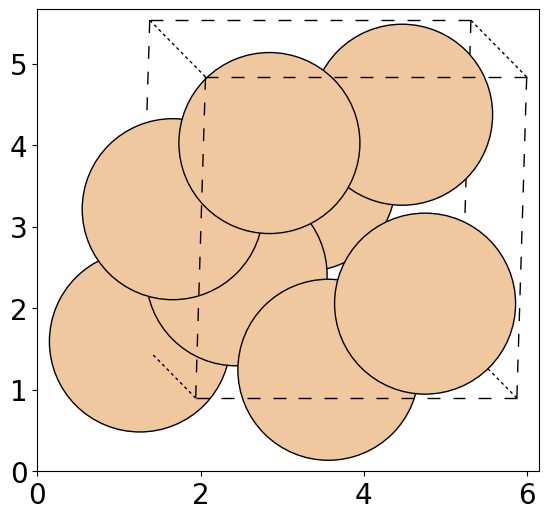

In [19]:
fig, ax = plt.subplots()
plot_atoms(SiDiamond, rotation='10x, 10y', ax=ax)

o bien, para poder rotarlo a mano (pero no se si anda en google colab)


In [20]:
#view(SiDiamond)

Una forma más presentable de visualizar las estructuras es usando por ejemplo [VESTA](http://www.jp-minerals.org/vesta/en/download.html) 

# Generamos la estructura con defectos Sustitucionales

Para poner un defecto sustitucional, basta con reemplazar un átomo del objeto atoms. Más fácil que en gmsh.

In [21]:
# hago copia de "SiDiamond", para no perderla y además poner defecto sustitucional.
SiBDiamond = SiDiamond.copy()
symbols = SiBDiamond.get_chemical_symbols()
symbols

['Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si', 'Si']

Atom('B', [0.0, 0.0, 0.0], index=0)
Atom('Si', [1.0, 1.0, 1.0], index=1)
Atom('Si', [0.0, 2.0, 2.0], index=2)
Atom('Si', [1.0, 3.0, 3.0], index=3)
Atom('Si', [2.0, 0.0, 2.0], index=4)
Atom('Si', [3.0, 1.0, 3.0], index=5)
Atom('Si', [2.0, 2.0, 0.0], index=6)
Atom('Si', [3.0, 3.0, 1.0], index=7)


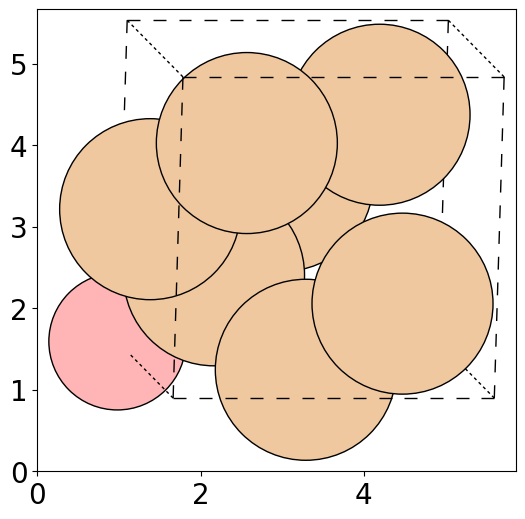

In [22]:
# Introduzco un átomo de BORO en el índice 0 de "SiBDiamond"; dopé con B en la posición [0,0,0].
symbols[0] = 'B'   # para hacerlo, modifico "symbols"
SiBDiamond.set_chemical_symbols(symbols)   # y a partir del "symbols" modificada, es que actualizo "SiBDiamond"
print_newatoms = [print(at) for at in SiBDiamond]
plot_atoms(SiBDiamond, rotation='10x, 10y')

**Aunque un poco más elegante sería**

1) pasar Objeto Atoms a una lista normal:

``` python
SiDiamondList = [at for at in SiDiamond]
```

2) cambiar el primer objeto de la lista:

``` python
SiDiamondList[0]=Atom('B', position=SiDiamond[0].position)
```

y despues volver a pasarlo a objeto Atoms:

``` python
SiBDiamond=Atoms(SiDiamondList, cell=SiDiamond.cell, pbc=True)
```

In [23]:
# Creo lista normal, con los elementos de la original "SiDiamond".
SiDiamondList = [at for at in SiDiamond]
# Con "atom" defino el átomo de B, le asigno posición que tenía el Si en "SiDiamond", y guardo en la lista "SiDiamondList".
SiDiamondList[0]=Atom('B', position=SiDiamond[0].position)
# Con "atoms", defino la celda (igual a la de "SiDiamond", usando comando ".cell") con condiciones periódicas de borde en los 3 ejes (pbc=True), a partir de
# lo que contiene "SiDiamondList".
SiCDiamond=Atoms(SiDiamondList, cell=SiDiamond.cell, pbc=True)
print_newnew_atoms = [print(at) for at in SiCDiamond]

Atom('B', [0.0, 0.0, 0.0], index=0)
Atom('Si', [1.0, 1.0, 1.0], index=1)
Atom('Si', [0.0, 2.0, 2.0], index=2)
Atom('Si', [1.0, 3.0, 3.0], index=3)
Atom('Si', [2.0, 0.0, 2.0], index=4)
Atom('Si', [3.0, 1.0, 3.0], index=5)
Atom('Si', [2.0, 2.0, 0.0], index=6)
Atom('Si', [3.0, 3.0, 1.0], index=7)


**Genero estructura de B**, para cálculos de energía de formación más adelante.

(!!!) **Problema:** La *estructura de equilibrio del B* debería ser romboédrica, pero no me está saliendo definirla así porque me dice que no se puede, así que la dejé diamante.

In [34]:
BRombo = bulk('B', 'diamond', a=4., cubic=True)

In [32]:
printatoms = [print(at) for at in BRombo]

Atom('B', [0.0, 0.0, 0.0], index=0)
Atom('B', [1.0, 1.0, 1.0], index=1)
Atom('B', [0.0, 2.0, 2.0], index=2)
Atom('B', [1.0, 3.0, 3.0], index=3)
Atom('B', [2.0, 0.0, 2.0], index=4)
Atom('B', [3.0, 1.0, 3.0], index=5)
Atom('B', [2.0, 2.0, 0.0], index=6)
Atom('B', [3.0, 3.0, 1.0], index=7)


# Tareas
1.  convergencia en puntos K y en ondas planas
2. Calcular curva E-V  y ajustar parámetro de red. ¿ Cambia mucho al cambiar un átomo solo ?
3. Calcular estructura electrónica, i.e. densidad de estados. ¿Qué cambia ? 

# Definimios la calculadora

Primero, calculamos usando la celda de Si SIN DOPAR con B.

In [37]:
# Tomo expansión en ondas planas hasta "300 eV" (energía cinética de corte). Más agarre, más precisión.
# Divido el cubo en grilla de "5*5*5". Más divisiones, más precisión, más tiempo de cálculo.
calc = GPAW(mode=PW(300), xc='PBE', txt='SiDiamondExample.txt',kpts=[5,5,5])
SiDiamond.set_calculator(calc)
SiDiamond.get_potential_energy()

30.841227127871782

Segundo, calculamos usando la celda de Si DOPADA con B

In [38]:
# Tomo expansión en ondas planas hasta "300 eV" (energía cinética de corte). Más agarre, más precisión.
# Divido el cubo en grilla de "5*5*5". Más divisiones, más precisión, más tiempo de cálculo.
calc = GPAW(mode=PW(300), xc='PBE', txt='SiBDiamondExample.txt',kpts=[5,5,5])
SiBDiamond.set_calculator(calc)
SiBDiamond.get_potential_energy()

15.080646295463513

Tercero, calculamos usando la celda de B

In [36]:
# Tomo expansión en ondas planas hasta "300 eV" (energía cinética de corte). Más agarre, más precisión.
# Divido el cubo en grilla de "5*5*5". Más divisiones, más precisión, más tiempo de cálculo.
calc = GPAW(mode=PW(300), xc='PBE', txt='BRomboExample.txt',kpts=[5,5,5])
BRombo.set_calculator(calc)
BRombo.get_potential_energy()

-44.80448881252707

**Conclusión:** Al dopar Si diamante con un átomo de B en la posición (0,0,0), *la energía potencial se reduce prácticamente a la mitad*.

<div style="background:#999900"> esto en si no quiere decir mucho porque estas cambiando la composición química y porque no estas seguro de que el parametro de red sea correcto. La forma de comparar estas energías es calculando la energía de formación:
    </div>
    

    
$$ \Delta E_f = \dfrac{1}{N} \left( E_{compuesto} - \sum_{i} n_i E_i \right) $$

    
<div style="background:#999900">
donde $N$ es el número de átomos, $E_{compuesto}$ es la energía del compuesto calculada, $n_i$ es el número de átomos de la especie $i$ en el compuesto y $E_i$ es la energía por átomo del compuesto $i$ en su estructura de equilibrio. Es decir, tendrías que:
    1. Calcular la curva E-V para cada elemento del compuesto puro (ie Si diamond y boro loquefuere)
    2) calcular la curva E-B para el Si-B
    3) calcular la energía de formación
</div>

 

(!!!) **Consulta:** Quiero saber si entendí bien lo que debo utilizar para calcular $\Delta E_f$:
- $N$ lo obtengo con el comando "struc.get_global_number_of_atoms()", que usamos en algunas ocasiones más adelante para normalizar por número de átomos.
- $E_{compuesto}$ la obtengo con el gráfico E-V (**ajuste con EOS**), para el V mínimo.
- $n_i$ para $SiDiamond$ va a ser $n_{Si} = N$, mientras que para $SiBDiamond$ van a ser $n_{Si} = N -1$ y $n_{B} = 1$. ¿Hay alguna función que me permita obtenerlos sin tener que definirlos así **a mano**? Como si fuera "struc.get_global_number_of_atoms()" pero usando de forma diferente.
- No entendí bien qué valor de $E_i$ utilizar. Lo que entendí de lo de más arriba fue plantear las estructuras de equilibrio del Si ($SiDiamond$) y del B ($BRombo$), y para cada una de ellas obtener la curva E-V. Ella devuelve una energía $E$, que yo dividiría por el número de átomos $N$ y así consideraría la energía por átomo de compuesto $E_i = E / N$ ¿está bien eso? Le veo dos problemas, porque me va a dar nula la energía de formación del SiDiamante, y además no encuentro la energía del B cúbico porque no me converge (**ver curvas E-V de más adelante**), ¿hay algún valor de tabla que pueda tomar así soluciono este problema? El cálculo intenté empezar a plantearlo justo antes del apartado Densidad de estados, pero me faltan definir $E_{Si}$ y $E_{B}$

# K-point convergence

Defino las tres estructuras en las que evaluaré la convergencia en puntos K:
- $SiDiamond$, Si puro.
- $SiBDiamond$, dopada con B.
- $BRombo$, B puro. Usé $a=2$ porque lo vi en bibliografía (https://dialnet.unirioja.es/servlet/articulo?codigo=2289371)

In [39]:
structures = [('pure', SiDiamond, 5.5), ('wBoron', SiBDiamond, 5.25), ('pureBoron', BRombo, 2)] # Nombre, estructura, parámetro de red.

In [42]:
print(structures[0])

('pure', Atoms(symbols='Si8', pbc=True, cell=[4.0, 4.0, 4.0], calculator=GPAW(...)), 5.5)


In [43]:
print(structures[0][0])

pure


In [44]:
kpoints = [3, 4, 5,7,9,11,13,14,15] # Grillas a ensayar
Ekpt = {} # Guardaré, para cada estructura (name), la información de las grillas en un diccionario

Para no tener que hacer las cuentas de nuevo cada vez que corres este loop podes definir un archivo donde 
guradrar los resultados y probar si existe antes de hacer la cuenta

In [45]:
import os

In [46]:
calcsdir='calcs_kpoints'
if not os.path.exists(calcsdir):
    os.makedirs(calcsdir)

In [47]:
import pdb

In [48]:
for case in structures:
    name, struc, latpar = case
    Ekpt[name] = np.array([])
    for kpt in tqdm(kpoints):
        gpawfile =os.path.join(calcsdir, f'{name}_kpts_{kpt}.gpaw')
        logfile = os.path.join(calcsdir, f'{name}_{kpt}.txt')
        # Energía cinética de corte 300 eV. Divido celda en grilla de "kpt*kpt*kpt".
        calc = load_calc(gpawfile, mode=PW(300), txt=logfile, xc='PBE', kpts=[kpt,kpt,kpt])
        struc.set_calculator(calc)
        # Divide la energía potencial por el número de átomos, para normalizar, por si llegara a comparar estructuras con diferente cantidad de átomos.
        Ekpt[name]=np.append(Ekpt[name], struc.get_potential_energy()/struc.get_global_number_of_atoms())
        struc.calc.write(gpawfile)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Imprimo energías potenciales de $SiDiamond$

In [49]:
print(Ekpt[structures[0][0]])

[3.82942361 3.84226176 3.85515339 3.85366022 3.84680203 3.84643687
 3.84849821 3.8486624  3.8487114 ]


Imprimo energías potenciales de $SiBDiamond$

In [50]:
print(Ekpt[structures[1][0]])

[1.87559467 1.87535473 1.88508079 1.87945832 1.87788234 1.87564313
 1.87482283 1.87463    1.87466355]


Imprimo energías potenciales de $BRombo$

In [51]:
print(Ekpt[structures[2][0]])

[-5.45633261 -5.5799269  -5.6005611  -5.59499388 -5.59365345 -5.59453086
 -5.59319022 -5.59339656 -5.59357746]


**Conclusión:** De nuevo, las energías asociadas al Si dopado con B son menores.

Defino la siguiente función por si me sirve más adelante, sirve para borrar elementos de un diccionario. Así, por ejemplo, puedo decidir qué comparo con qué, y no tengo que siempre estar comparado Si puro, B puro y Si-B.

In [53]:
# Para borrar elementos del diccionario.
def removekey(d, key):
    r = dict(d)
    del r[key]
    return r

In [58]:
No_B_Ekpt = removekey(Ekpt, structures[-1][0])
print(No_B_Ekpt)

{'pure': array([3.82942361, 3.84226176, 3.85515339, 3.85366022, 3.84680203,
       3.84643687, 3.84849821, 3.8486624 , 3.8487114 ]), 'wBoron': array([1.87559467, 1.87535473, 1.88508079, 1.87945832, 1.87788234,
       1.87564313, 1.87482283, 1.87463   , 1.87466355])}


In [63]:
B_Ekpt = removekey(Ekpt, structures[0][0])
B_Ekpt = removekey(B_Ekpt, structures[1][0])
print(B_Ekpt)

{'pureBoron': array([-5.45633261, -5.5799269 , -5.6005611 , -5.59499388, -5.59365345,
       -5.59453086, -5.59319022, -5.59339656, -5.59357746])}


***Convergencia*** significa que la diferencia de energía entre un cierto K y el último K, dividida por la energía del último K, es menor a un determinado margen establecido.

**Este cociente** es lo que se grafica a continuación, en función del número de puntos K.

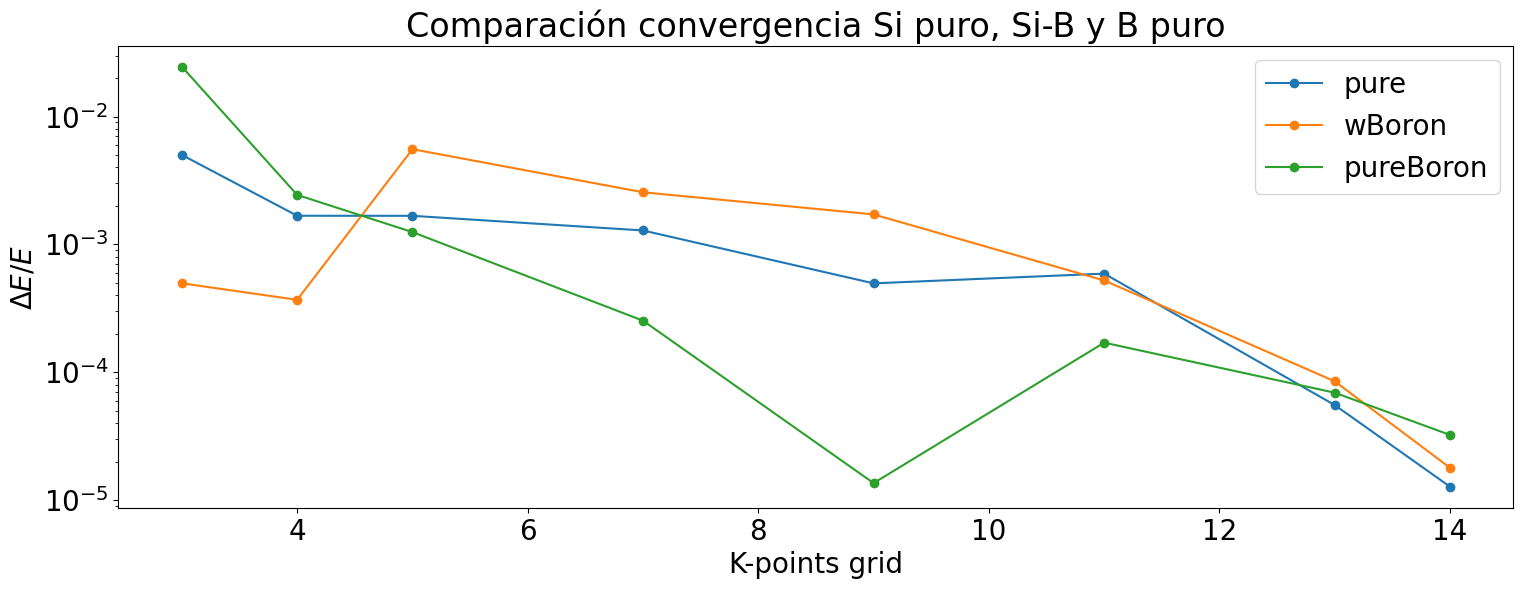

In [70]:
plots = [plt.plot(kpoints[:-1], econvergence(energies), '-o', label = struc) for struc, energies in Ekpt.items()]
plt.yscale('log')
plt.ylabel('$\Delta E / E$')
plt.xlabel('K-points grid')
plt.title('Comparación convergencia Si puro, Si-B y B puro')
plt.legend()

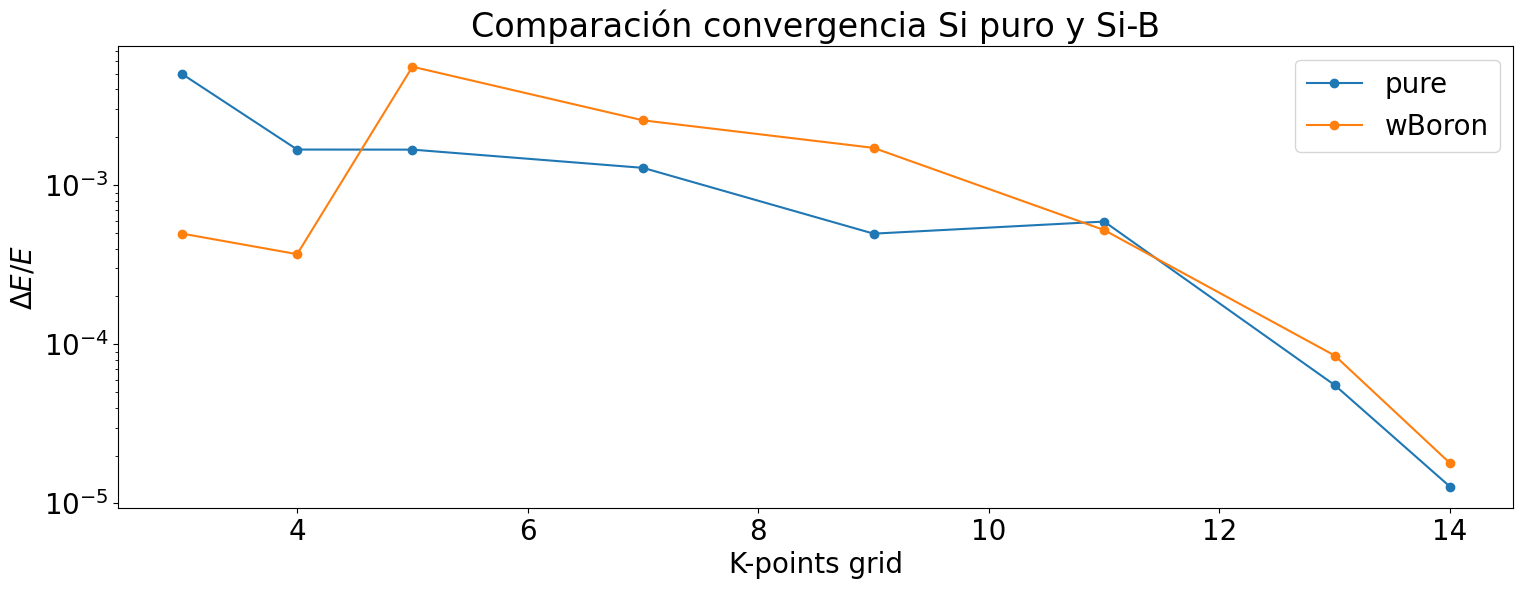

In [71]:
plots = [plt.plot(kpoints[:-1], econvergence(energies), '-o', label = struc) for struc, energies in No_B_Ekpt.items()]
plt.yscale('log')
plt.ylabel('$\Delta E / E$')
plt.xlabel('K-points grid')
plt.title('Comparación convergencia Si puro y Si-B')
plt.legend()

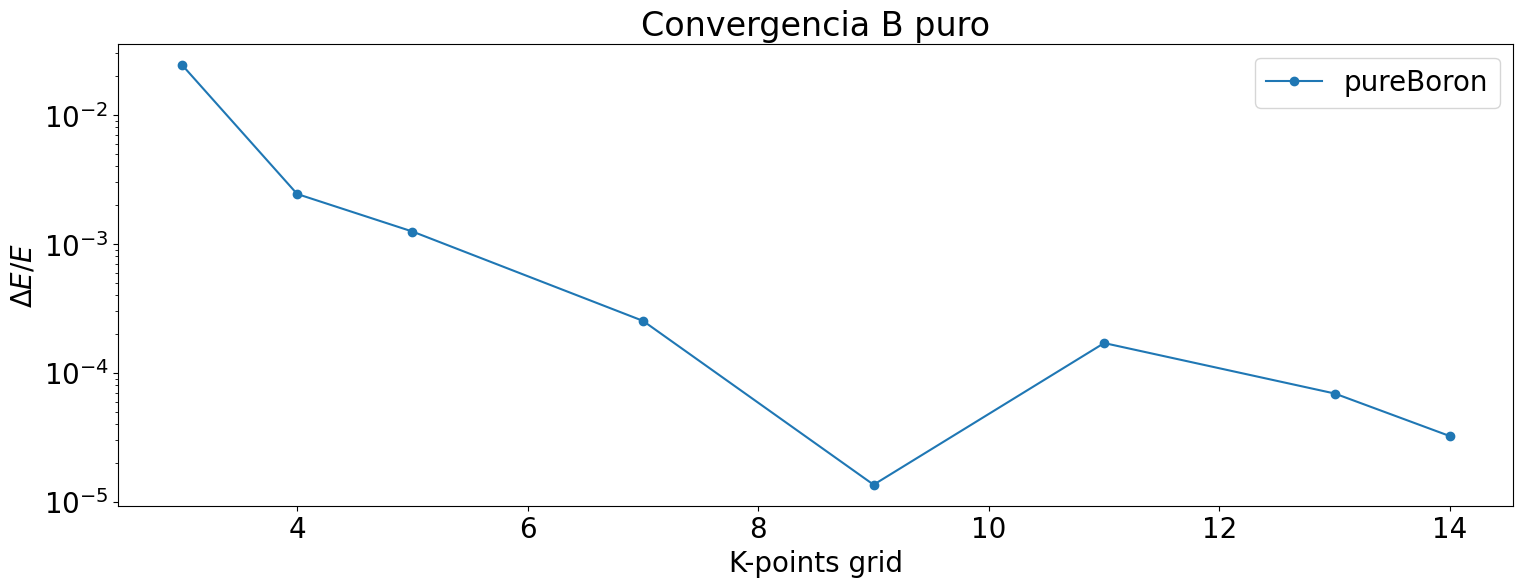

In [72]:
plots = [plt.plot(kpoints[:-1], econvergence(energies), '-o', label = struc) for struc, energies in B_Ekpt.items()]
plt.yscale('log')
plt.ylabel('$\Delta E / E$')
plt.xlabel('K-points grid')
plt.title('Convergencia B puro')
plt.legend()

**Conclusión:** Hay convergencia a partir de $K = 11$. Deberé tomar grillado de $11*11*11$.

In [73]:
KPT = 11

# cutoff convergence

In [86]:
ecuts = [200, 250, 300, 350, 400, 450, 500, 600] # Energías cinéticas de corte (como la que habíamos usado de 300 eV arriba).
Ecutoff = {} # Guardaré, para cada estructura (name), la información de las energías de corte en un diccionario

<div style="background:#999900"> igual que antes, usamos archivos para evitar recalcular todo </div>

In [87]:
calcsdir = 'calcs_ecut'
if not os.path.exists(calcsdir):
    os.makedirs(calcsdir)

In [88]:
for case in structures:
    name, struc, latpar = case
    Ecutoff[name] = np.array([])
    progress = tqdm(ecuts)
    for ecut in progress:
        filename = os.path.join(calcsdir, f'{name}_{ecut}.gpaw')
        logfilename = os.path.join(calcsdir, f'{name}_{ecut}.txt')
        # Energía cinética de corte "ecut" eV. Divido celda en grilla de "KPT*KPT*KPT".
        calc = load_calc(filename, mode=PW(ecut), txt=logfilename, xc='PBE', kpts=[KPT,KPT,KPT])
        struc.set_calculator(calc)
        # Divide la energía potencial por el número de átomos, para normalizar, por si llegara a comparar estructuras con diferente cantidad de átomos.
        Ecutoff[name]=np.append(Ecutoff[name], struc.get_potential_energy()/struc.get_global_number_of_atoms())
        struc.calc.write(filename)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [89]:
Ecutoff

{'pure': array([3.85598245, 3.84828234, 3.84643687, 3.84514617, 3.84383355,
        3.84336176, 3.84310033, 3.84278573]),
 'pureBoron': array([-4.95683749, -5.38781095, -5.59453086, -5.67983593, -5.72144061,
        -5.73557949, -5.73882006, -5.74180857]),
 'wBoron': array([1.9960631 , 1.91424633, 1.87564313, 1.85894379, 1.851634  ,
        1.84932483, 1.84860984, 1.84796209])}

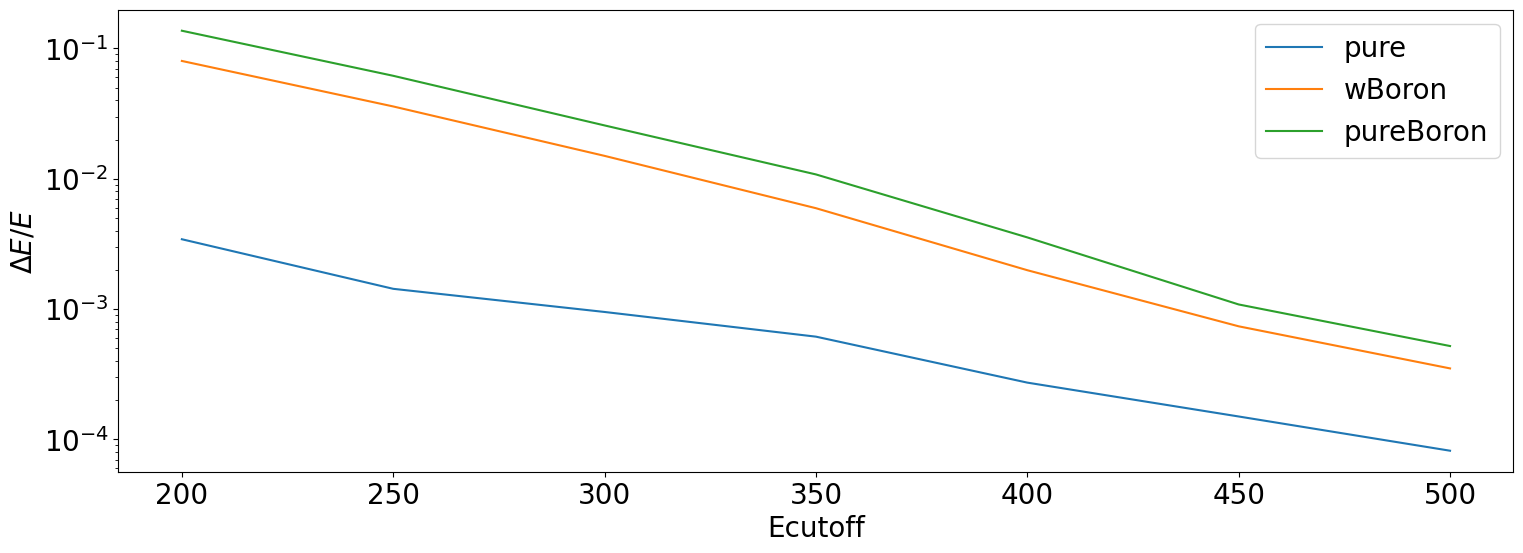

In [91]:
[plt.plot(ecuts[:-1], econvergence(energies), label = struc) for struc, energies in Ecutoff.items()]
plt.yscale('log')
plt.ylabel('$\Delta E /E$')
plt.xlabel('Ecutoff')
plt.legend()

**Conclusión:** Hay convergencia a partir de $E = 450$. Deberé tomar energía cinética de corte $ECUT = 450$.

In [90]:
ECUT = 450

# Lattice Parameter


``` python
# Hago loop sobre los parámetros de red, y para dada estructura calculo la energía asociada a utilizar ese parámetro de red. Obendré energías en función de
# parámatro de red (en realidad cubo de parámetro de red, volumen), y así puedo obtener el parámetro de red que minimiza la energía.
latparams = {'diamond': np.linspace(4.8,5.5,10), 'wBoron': np.linspace(4.8, 5.5, 10)}
def evcurve(element: str, structure, sizes: np.ndarray, calculator):
    """
    Parametros:
    alement: str con el nombre de la estructura
    structure: nombre de a estructura para generar el atoms object.
    sizes: lista de parámetros de red
    calculator: calculadora GPAW.
    
    """
    print(f'working on {element} in {structure}')
    structures = []
    E = []
    V = []
    progress = tqdm(sizes)
    for a in progress:
        calc = GPAW(mode=PW(ECUT), xc='PBE', txt=f'{element}{structure}_{a}.txt',kpts=[KPT,KPT,KPT])
        structures.append(bulk(element, structure, a=a, cubic=True))
        structures[-1].set_calculator(calculator)
        E.append(structures[-1].get_potential_energy())
        V.append(structures[-1].get_volume())
    return {'E': E, 'V': V, 'strucs': structures}
```

<div style="background:999900" > en realidad la función de arriba hay que cambiarla un poco porque vos vas a quere darle los objetos atoms ya armados, en lugar de armarlos dentro del loop. Dentro del loop solo vas a querer cambarles el parámetro de red. </div>

In [92]:
structures

[('pure',
  Atoms(symbols='Si8', pbc=True, cell=[4.0, 4.0, 4.0], calculator=GPAW(...)),
  5.5),
 ('wBoron',
  Atoms(symbols='BSi7', pbc=True, cell=[4.0, 4.0, 4.0], calculator=GPAW(...)),
  5.25),
 ('pureBoron',
  Atoms(symbols='B8', pbc=True, cell=[4.0, 4.0, 4.0], calculator=GPAW(...)),
  2)]

In [93]:
latparcalcs = 'calcs_latpar'

In [94]:
if not os.path.exists(latparcalcs):
    os.makedirs(latparcalcs)

In [95]:
import ase, gpaw
def doevcurve(name: str, struc: ase.atoms.Atoms, sizes: np.ndarray, gpaw_kwargs:dict):
    """
    name: str con el nombre de la estructura
    struc: atoms object con la estructura a calcular
    sizes: np.ndarray con los parametros de red para esta estructura
    gpaw_kwargs: opciones para gpaw
    """
    E = []
    V = []
    progress = tqdm(sizes)
    for latpar in progress:
        gpawfile = os.path.join(latparcalcs, f'{name}_latpar_{latpar:.2f}.gpaw')
        logfile = os.path.join(latparcalcs, f'{name}_latpar_{latpar:.2f}.txt')
        gpaw_kwargs.update({'txt': logfile})
        calc = load_calc(gpawfile, **gpaw_kwargs)
        struc.set_cell(latpar*np.eye(3), scale_atoms=True) # ojo, esto vale solo para cubicas !
        struc.set_calculator(calc)
        V.append(struc.get_volume())
        E.append(struc.get_potential_energy())
        struc.calc.write(gpawfile)
    return {'V': V, 'E': E}
        
        

In [96]:
GPAW_KWARGS = dict(mode=PW(ECUT), xc='PBE', kpts=[KPT,KPT,KPT])

In [97]:
evcurves={}

In [98]:
for case in structures:
    name, struc, guess = case
    print(guess)
    # Se había supuesto "a=guess", pero ahora se supondrán 10 valores de "a" en un entorno de "guess", para obtener el más óptimo.
    latparams = np.linspace(guess*0.95, guess*1.05, 10)
    evcurves[name] = doevcurve(name,struc, latparams, GPAW_KWARGS)

5.5


  0%|          | 0/10 [00:00<?, ?it/s]

5.25


  0%|          | 0/10 [00:00<?, ?it/s]

2


  0%|          | 0/10 [00:00<?, ?it/s]

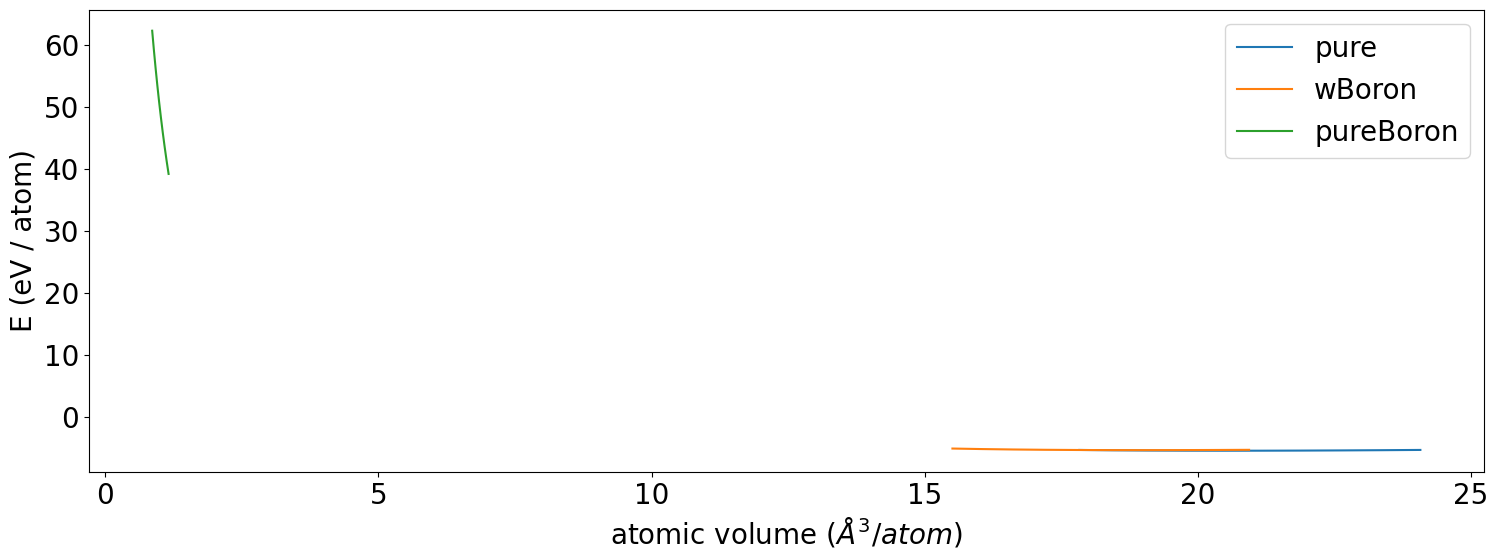

In [115]:
for (name, evcurve), case in zip(evcurves.items(), structures):
    structure = case[1]
    natoms = structure.get_global_number_of_atoms()
    plt.plot(np.array(evcurve['V'])/natoms,np.array(evcurve['E'])/natoms, label=name)
plt.legend()
xlabel=plt.xlabel('atomic volume ($\AA ^3 / atom $)')
ylabel = plt.ylabel('E (eV / atom)')

**Conclusión:** Se ve mal, así que haré cosas a continuación.

Para hacer gráficos comparando Si puro y Si-B.

In [104]:
No_B_structures = structures[:-1]
print(No_B_structures)

[('pure', Atoms(symbols='Si8', pbc=True, cell=[5.775, 5.775, 5.775], calculator=GPAW(...)), 5.5), ('wBoron', Atoms(symbols='BSi7', pbc=True, cell=[5.5125, 5.5125, 5.5125], calculator=GPAW(...)), 5.25)]


In [114]:
No_B_evcurves = removekey(evcurves, structures[2][0])
print(No_B_evcurves)

{'pure': {'V': [142.64576562499994, 147.70964778377916, 152.8919779878257, 158.19412557870368, 163.61745989797663, 169.16335028720852, 174.83316608796287, 180.62827664180378, 186.55005129029504, 192.59985937499994], 'E': [-42.19878678921956, -42.64681196289093, -42.95329675981495, -43.13191064984286, -43.19561422428336, -43.15631212393065, -43.0250543219745, -42.81199181009701, -42.5266848283619, -42.17778480705893]}, 'wBoron': {'V': [124.06484179687503, 128.46910669849538, 132.976390697338, 137.58788476562498, 142.30477987557865, 147.1282669994213, 152.05953710937504, 157.0997811776621, 162.25019017650456, 167.51195507812508], 'E': [-40.388070062816304, -41.073602084857505, -41.60397878648098, -41.993199994786146, -42.25444468515435, -42.399658762398886, -42.440359260278974, -42.38684798328774, -42.24893507197344, -42.03567410387927]}}


Atoms(symbols='Si8', pbc=True, cell=[5.775, 5.775, 5.775], calculator=GPAW(...))
Atoms(symbols='BSi7', pbc=True, cell=[5.5125, 5.5125, 5.5125], calculator=GPAW(...))


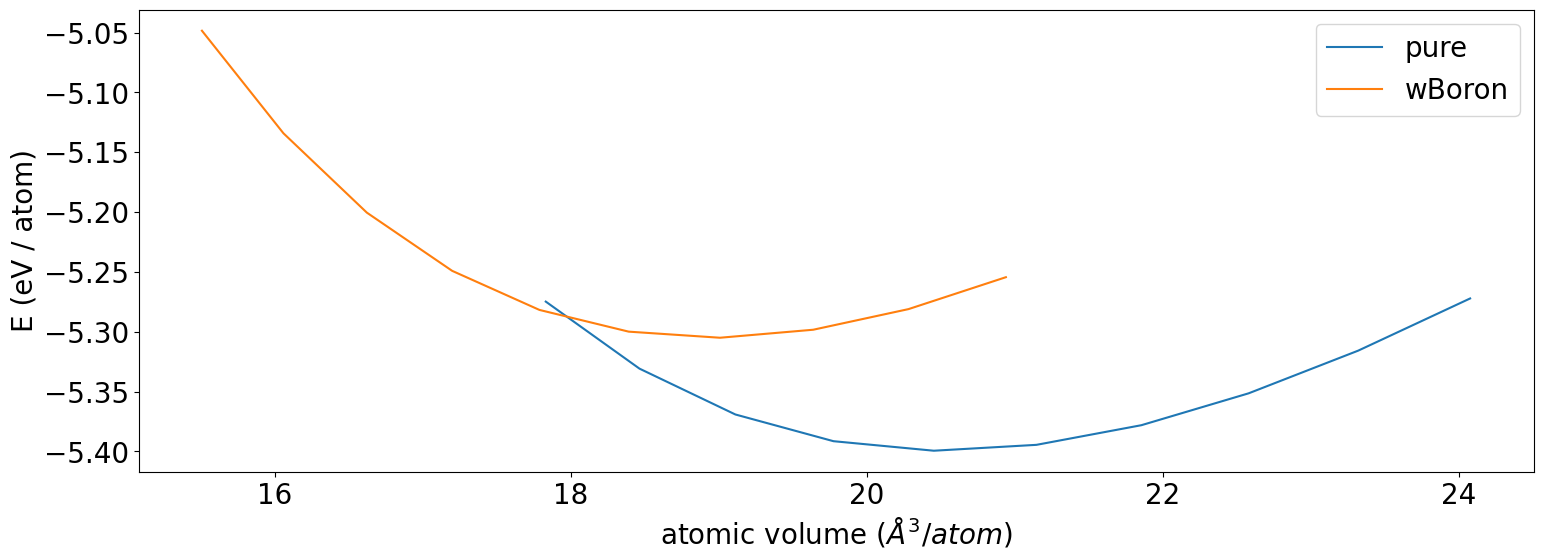

In [124]:
for (name, evcurve), case in zip(No_B_evcurves.items(), No_B_structures):
    structure = case[1]
    print(structure)
    natoms = structure.get_global_number_of_atoms()
    plt.plot(np.array(evcurve['V'])/natoms,np.array(evcurve['E'])/natoms, label=name)
plt.legend()
xlabel=plt.xlabel('atomic volume ($\AA ^3 / atom $)')
ylabel = plt.ylabel('E (eV / atom)')

Para hacer gráfico de sólo B puro.

In [133]:
B_structures = [structures[2]]
print(B_structures)

[('pureBoron', Atoms(symbols='B8', pbc=True, cell=[2.1, 2.1, 2.1], calculator=GPAW(...)), 2)]


In [134]:
B_evcurves = removekey(evcurves, structures[0][0])
B_evcurves = removekey(B_evcurves, structures[1][0])
print(B_evcurves)

{'pureBoron': {'V': [6.858999999999997, 7.10249245541838, 7.351680384087792, 7.60662962962963, 7.867406035665295, 8.134075445816185, 8.4067037037037, 8.685356652949244, 8.97010013717421, 9.261], 'E': [498.29404691628963, 473.9495035082585, 450.65514483527556, 428.3682224053513, 407.04415012935203, 386.6551352677083, 367.16191362162465, 348.5193175337445, 330.70074133773244, 313.66240041374607]}}


Atoms(symbols='B8', pbc=True, cell=[2.1, 2.1, 2.1], calculator=GPAW(...))


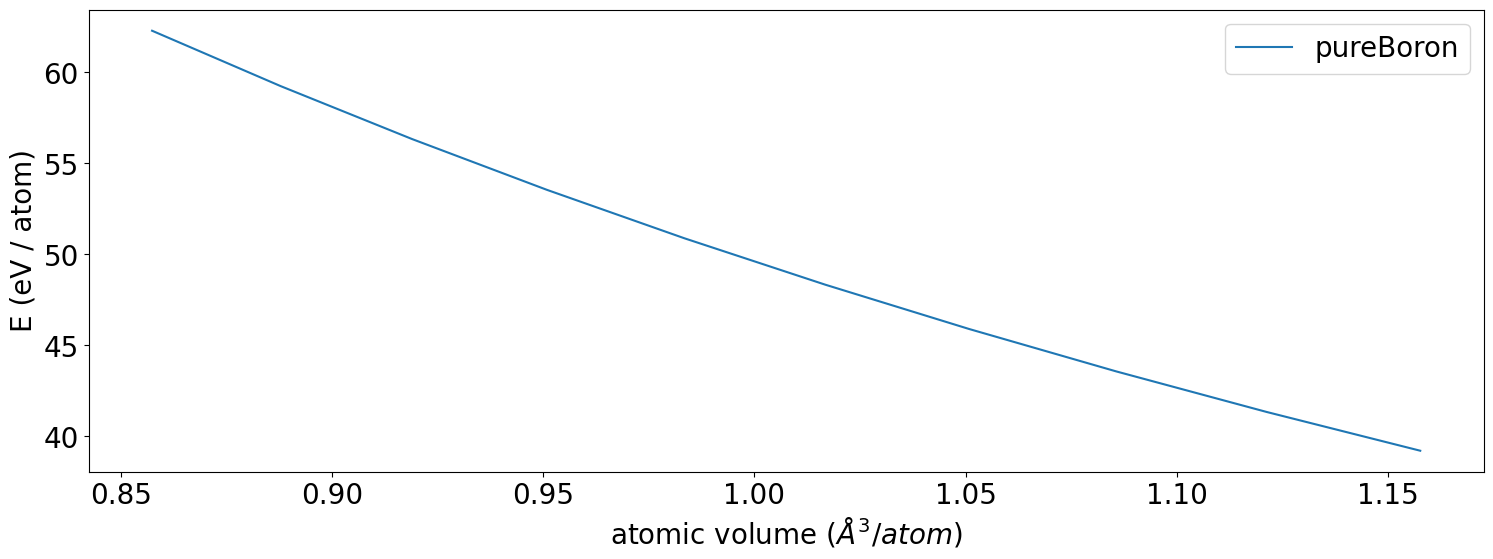

In [135]:
for (name, evcurve), case in zip(B_evcurves.items(), B_structures):
    structure = case[1]
    print(structure)
    natoms = structure.get_global_number_of_atoms()
    plt.plot(np.array(evcurve['V'])/natoms,np.array(evcurve['E'])/natoms, label=name)
plt.legend()
xlabel=plt.xlabel('atomic volume ($\AA ^3 / atom $)')
ylabel = plt.ylabel('E (eV / atom)')

(!!!) **Problema:** No me encontró mínimo, debería probar con otro parámetro de red pero no sé cuál usar, porque el B en realidad no es cúbico, pero en los casos en que lo es el parámetro de red valdría 2 Angstrom.

En el gráfico se representó la Energía dividida por el número de átomos que componen al mismo ($E / N$, con $N = 8$, para las 3), para que las energías sean comparables.

Podría buscar el volumen $V$ para el cual la energía es mínima ($E_{min}$), aplicarle raiz cúbica y obtener el parámetro de red $a$ óptimo. Sin embargo, no se recomienda y en su lugar conviene hacerlo realizando un ajuste con la **ecuación de estado**, lo que haremos a continuación.

# Ecuación de Estado 

Se realizará un *ajuste de la Energía vs. Volumen de celda*, empleando la **ecuación de estado de Birch-Murnaghan**.

### **Si puro**

In [136]:
eos_Si_puro = EquationOfState(evcurves['pure']['V'],evcurves['pure']['E'],eos='birchmurnaghan')

In [137]:
eos_Si_puro.fit()

(164.1648044159487, -43.19552566825436, 0.5502737275371057)

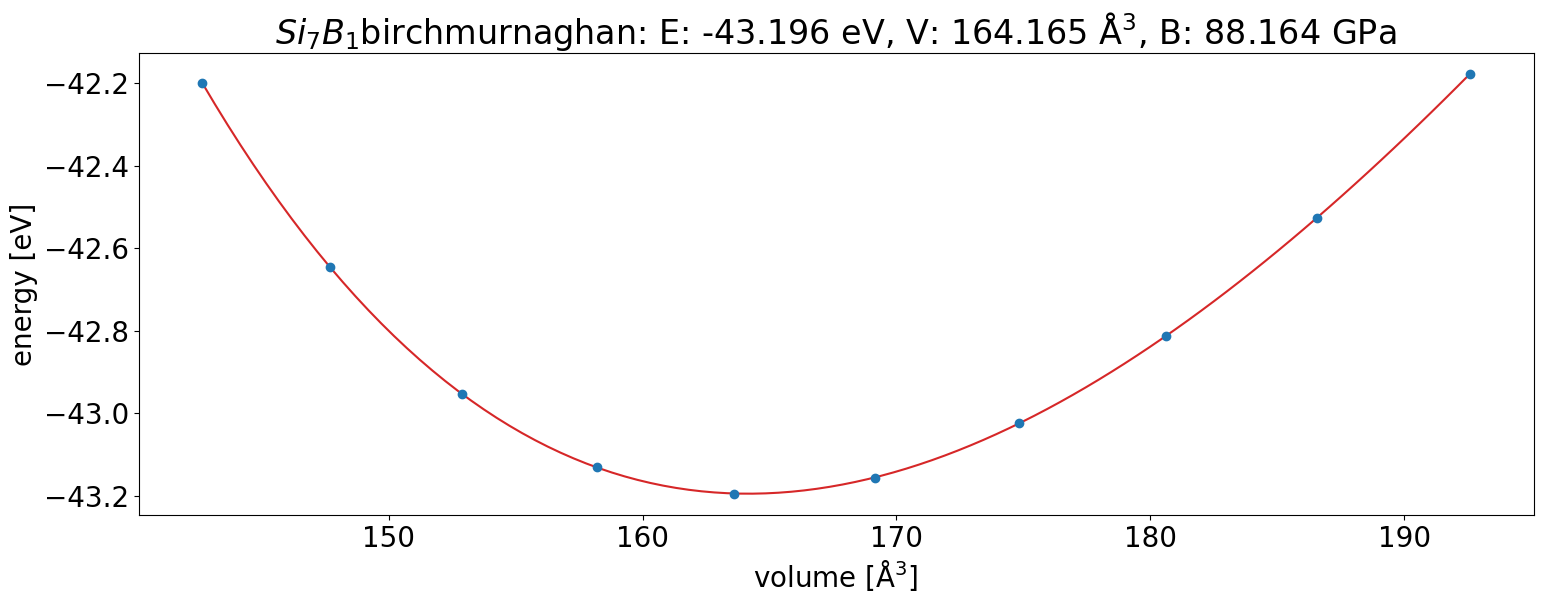

In [139]:
ax = eos_Si_puro.plot()
title = ax.get_title()
newtitle = ax.set_title('$Si_7 B_1$' + title)

Energía mínima.

In [142]:
E_Si_puro = eos_Si_puro.fit()[1]
print(E_Si_puro)

-43.19552566825436


Volumen que minimiza la energía.

In [143]:
V_Si_puro = eos_Si_puro.fit()[0]
print(V_Si_puro)

164.1648044159487


Parámetro de red que minimiza la energía (**parámetro de red en equilibrio**).

In [146]:
a_Si_puro = V_Si_puro**(1/3)
print(a_Si_puro)

5.475536578322877


Número de átomos de la estructura.

In [148]:
N_Si_puro = SiDiamond.get_global_number_of_atoms()
print(N_Si_puro)

8


### **Si-B**

In [149]:
eos_Si_B = EquationOfState(evcurves['wBoron']['V'],evcurves['wBoron']['E'],eos='birchmurnaghan')

In [150]:
eos_Si_B.fit()

(151.65992973895064, -42.4406721413218, 0.5805242253787347)

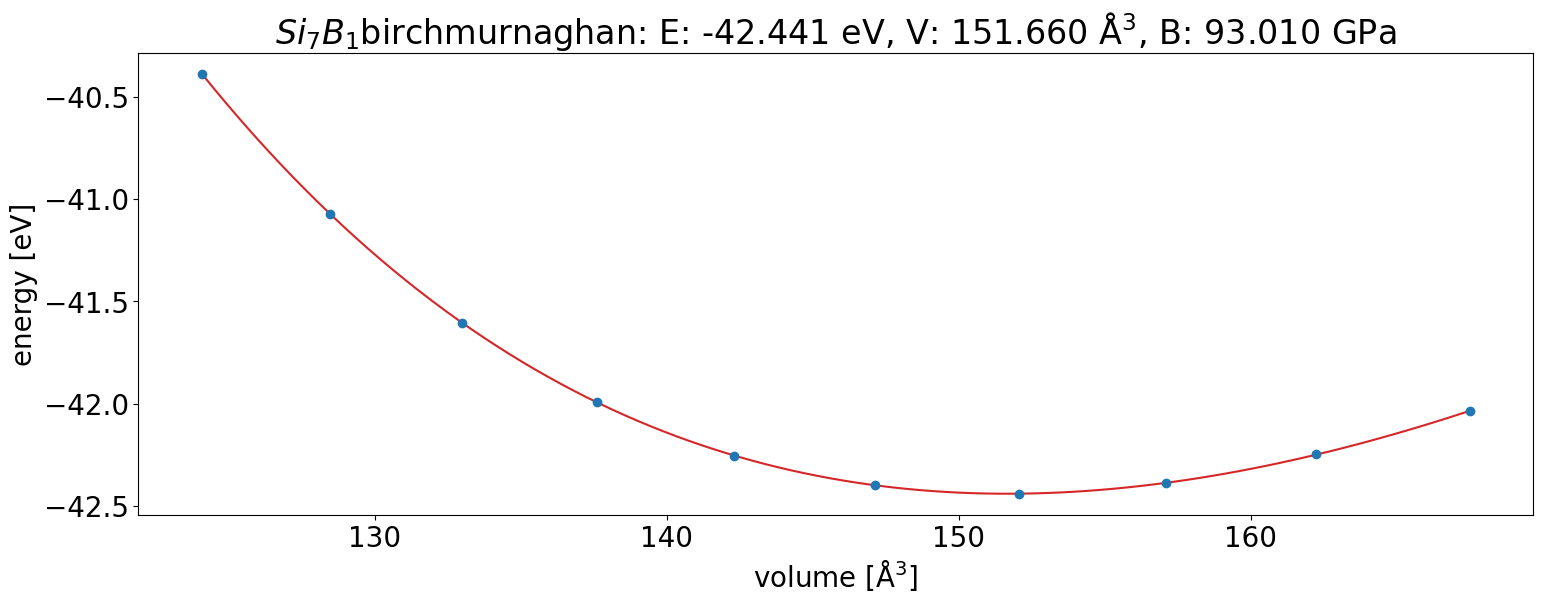

In [151]:
ax = eos_Si_B.plot()
title = ax.get_title()
newtitle = ax.set_title('$Si_7 B_1$' + title)

Energía mínima.

In [152]:
E_Si_B = eos_Si_B.fit()[1]
print(E_Si_B)

-42.4406721413218


Volumen que minimiza la energía.

In [153]:
V_Si_B = eos_Si_B.fit()[0]
print(V_Si_B)

151.65992973895064


Parámetro de red que minimiza la energía (**parámetro de red en equilibrio**).

In [154]:
a_Si_B = V_Si_B**(1/3)
print(a_Si_B)

5.332820307836372


Número de átomos de la estructura.

In [155]:
N_Si_B = SiBDiamond.get_global_number_of_atoms()
print(N_Si_B)

8


**Conclusión:** Al dopar SiDiamante con 1 átomo de B, **por un lado** se redujo el parámetro de red, **por otro lado** aumentó la energía del compuesto.

### **B puro**

(!!!) **Problema:** No anda, por lo mismo que me ocurrió arriba.

In [156]:
eos_B_puro = EquationOfState(evcurves['pureBoron']['V'],evcurves['pureBoron']['E'],eos='birchmurnaghan')

In [157]:
eos_B_puro.fit()

RuntimeError: ignored

In [ ]:
ax = eos_B_puro.plot()
title = ax.get_title()
newtitle = ax.set_title('$Si_7 B_1$' + title)

Energía mínima.

In [ ]:
E_B_puro = eos_B_puro.fit()[1]
print(E_B_puro)

Volumen que minimiza la energía.

In [ ]:
V_B_puro = eos_B_puro.fit()[0]
print(V_B_puro)

Parámetro de red que minimiza la energía (parámetro de red en equilibrio).

In [ ]:
a_B_puro = V_B_puro**(1/3)
print(a_B_puro)

Número de átomos de la estructura.

In [158]:
N_B_puro = BRombo.get_global_number_of_atoms()
print(N_B_puro)

8


# Cálculo de energías de formación de compuestos, $\Delta E_f$

In [162]:
# E_Si = XXX   # eV

In [163]:
# E_B = YYY   # eV

### Si puro

In [161]:
n_Si = N_Si_puro

In [159]:
# E_f_Si_puro = (1/N_Si_puro)*(E_Si_puro - (n_Si*E_Si/N_Si_puro))

### Si-B

In [166]:
n_Si = N_Si_B - 1
n_B = N_Si_B - n_Si

In [ ]:
# E_f_Si_B = (1/N_Si_B)*(E_Si_B - (n_Si*E_Si + n_B*E_B)/N_Si_B))

# Densidad de Estados 

A partir de aca tendrías que completar!

### Si puro

In [173]:
eq_SiDiamond = bulk('Si','diamond', a=a_Si_puro, cubic=True)

In [174]:
printatoms = [print(at) for at in eq_SiDiamond]

Atom('Si', [0.0, 0.0, 0.0], index=0)
Atom('Si', [1.3688841445807192, 1.3688841445807192, 1.3688841445807192], index=1)
Atom('Si', [0.0, 2.7377682891614383, 2.7377682891614383], index=2)
Atom('Si', [1.3688841445807192, 4.106652433742157, 4.106652433742157], index=3)
Atom('Si', [2.7377682891614383, 0.0, 2.7377682891614383], index=4)
Atom('Si', [4.106652433742157, 1.3688841445807192, 4.106652433742157], index=5)
Atom('Si', [2.7377682891614383, 2.7377682891614383, 0.0], index=6)
Atom('Si', [4.106652433742157, 4.106652433742157, 1.3688841445807192], index=7)


In [175]:
calc = GPAW(mode=PW(ECUT), xc='PBE', kpts=[KPT,KPT,KPT], txt='eq_SiDiamond.txt')
eq_SiDiamond.set_calculator(calc)
eq_SiDiamond.get_potential_energy()

-43.1961715988432

(!!!) **Observación:** No me dio igual que antes, me daba -43.1955, ¿es normal que esto suceda?

In [176]:
e,dos = eq_SiDiamond.calc.get_dos(npts=500)
ef = eq_SiDiamond.calc.get_fermi_level()

Text(0, 0.5, 'DOS')

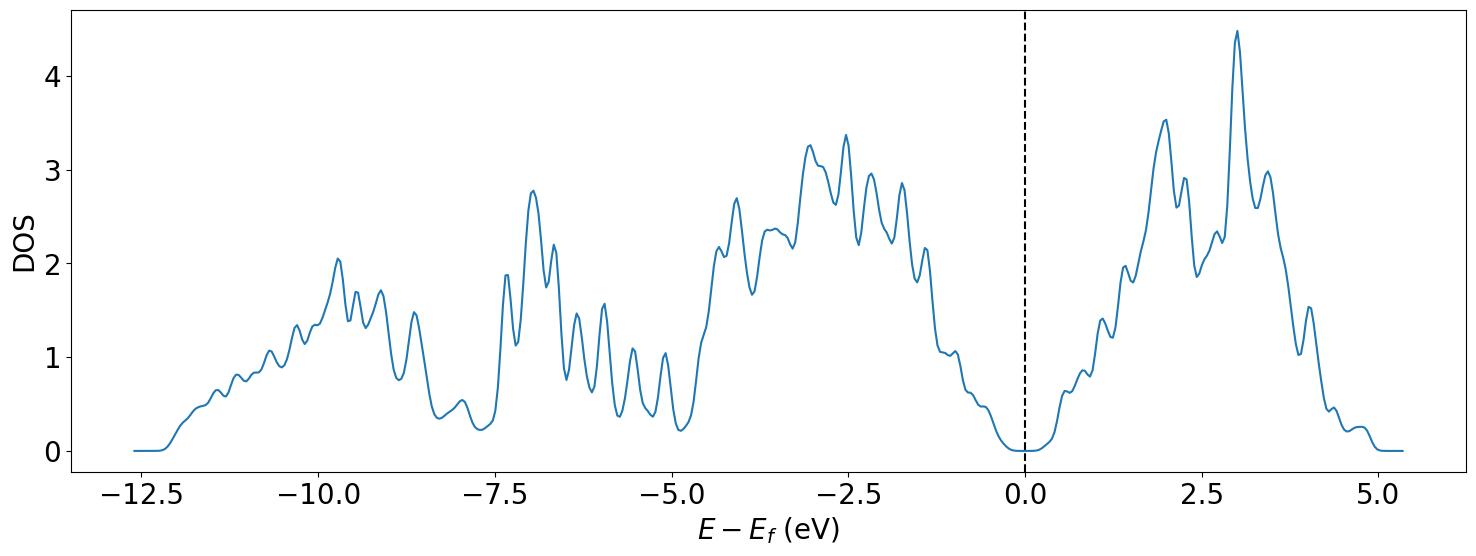

In [177]:
plt.plot(e-ef,dos)
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS')

(!!!) **Consulta:** ¿Qué puedo concluir del gráfico anterior?

In [178]:
eq_SiDiamond.calc.write('eq_SiDiamond.gpw')

In [179]:
bscalc_SiDiamond = GPAW('eq_SiDiamond.gpw').fixed_density(nbands=20, symmetry='off', txt='bs.txt', kpts={'path': 'GXMGRX', 'npoints': 60}, convergence={'bands': 8})

In [180]:
bs_SiDiamond = bscalc_SiDiamond.band_structure()

In [181]:
bs_SiDiamond = bs_SiDiamond.subtract_reference()

Text(0, 0.5, '$E-E_f$ (eV)')

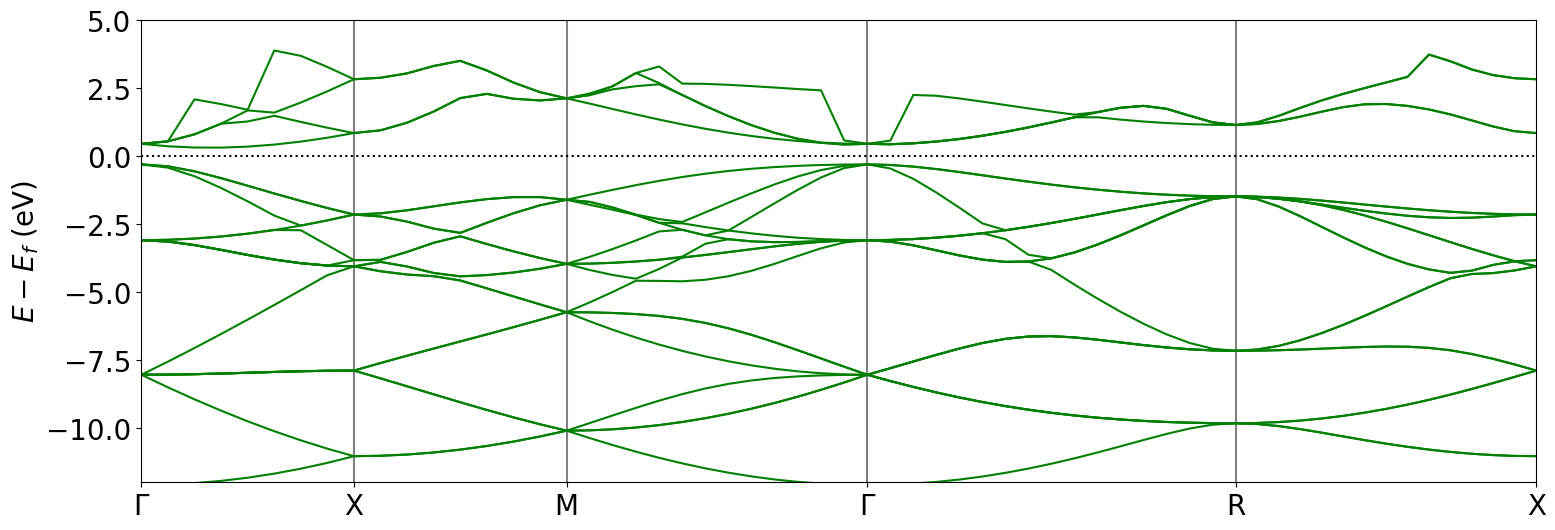

In [182]:
ax = bs_SiDiamond.plot(emin=-12, emax=5)
ax.set_ylabel('$E-E_f$ (eV)')

(!!!) **Consulta:** ¿Cómo podría hacer para extraer el gap, así lo comparo con el de Si-B? ¿Qué puedo decir del gráfico? ¿Hay más información que pueda obtener del gráfico?

### Si-B

In [183]:
# Creo lista normal, con los elementos de la original "eq_SiDiamond".
eq_SiDiamondList = [at for at in eq_SiDiamond]
# Con "atom" defino el átomo de B, le asigno posición que tenía el Si en "eq_SiDiamond", y guardo en la lista "eq_SiDiamondList".
eq_SiDiamondList[0] = Atom('B', position=eq_SiDiamond[0].position)
# Con "atoms", defino la celda (igual a la de "eq_SiDiamond", usando comando ".cell") con condiciones periódicas de borde en los 3 ejes (pbc=True), a partir
# de lo que contiene "eq_SiDiamondList".
eq_SiBDiamond = Atoms(eq_SiDiamondList, cell=eq_SiDiamond.cell, pbc=True)

In [184]:
print_new_atoms = [print(at) for at in eq_SiBDiamond]

Atom('B', [0.0, 0.0, 0.0], index=0)
Atom('Si', [1.3688841445807192, 1.3688841445807192, 1.3688841445807192], index=1)
Atom('Si', [0.0, 2.7377682891614383, 2.7377682891614383], index=2)
Atom('Si', [1.3688841445807192, 4.106652433742157, 4.106652433742157], index=3)
Atom('Si', [2.7377682891614383, 0.0, 2.7377682891614383], index=4)
Atom('Si', [4.106652433742157, 1.3688841445807192, 4.106652433742157], index=5)
Atom('Si', [2.7377682891614383, 2.7377682891614383, 0.0], index=6)
Atom('Si', [4.106652433742157, 4.106652433742157, 1.3688841445807192], index=7)


In [185]:
calc = GPAW(mode=PW(ECUT), xc='PBE', kpts=[KPT,KPT,KPT], txt='eq_SiBDiamond.txt')
eq_SiBDiamond.set_calculator(calc)
eq_SiBDiamond.get_potential_energy()

-42.179145685765

(!!!) **Observación:** No me dio igual que antes, me daba -42.4406, ¿es normal que esto suceda?

In [186]:
e,dos = eq_SiDiamond.calc.get_dos(npts=500)
ef = eq_SiDiamond.calc.get_fermi_level()

Text(0, 0.5, 'DOS')

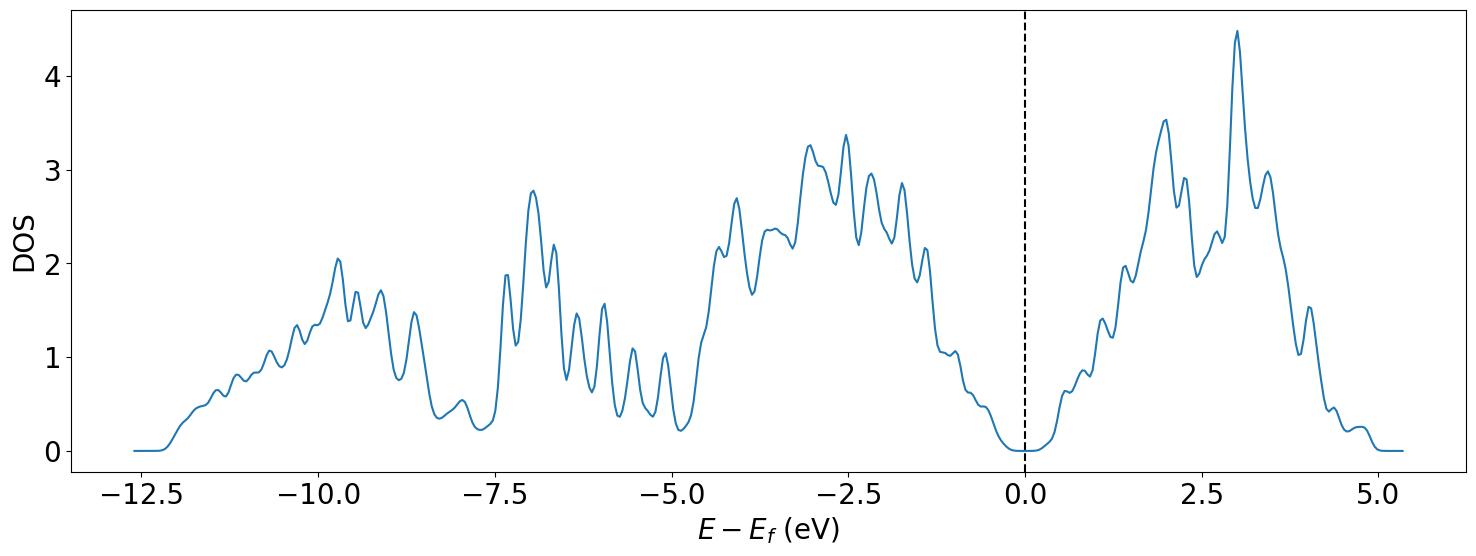

In [187]:
plt.plot(e-ef,dos)
plt.axvline(color='k', linestyle='--')
plt.xlabel('$E - E_f$ (eV)')
plt.ylabel('DOS')

(!!!) **Consulta:** ¿Qué puedo concluir del gráfico anterior?

In [188]:
eq_SiBDiamond.calc.write('eq_SiBDiamond.gpw')

In [189]:
bscalc_SiBDiamond = GPAW('eq_SiBDiamond.gpw').fixed_density(nbands=20, symmetry='off', txt='bs.txt', kpts={'path': 'GXMGRX', 'npoints': 60}, convergence={'bands': 8})

In [190]:
bs_SiBDiamond = bscalc_SiBDiamond.band_structure()

In [191]:
bs_SiBDiamond = bs_SiBDiamond.subtract_reference()

Text(0, 0.5, '$E-E_f$ (eV)')

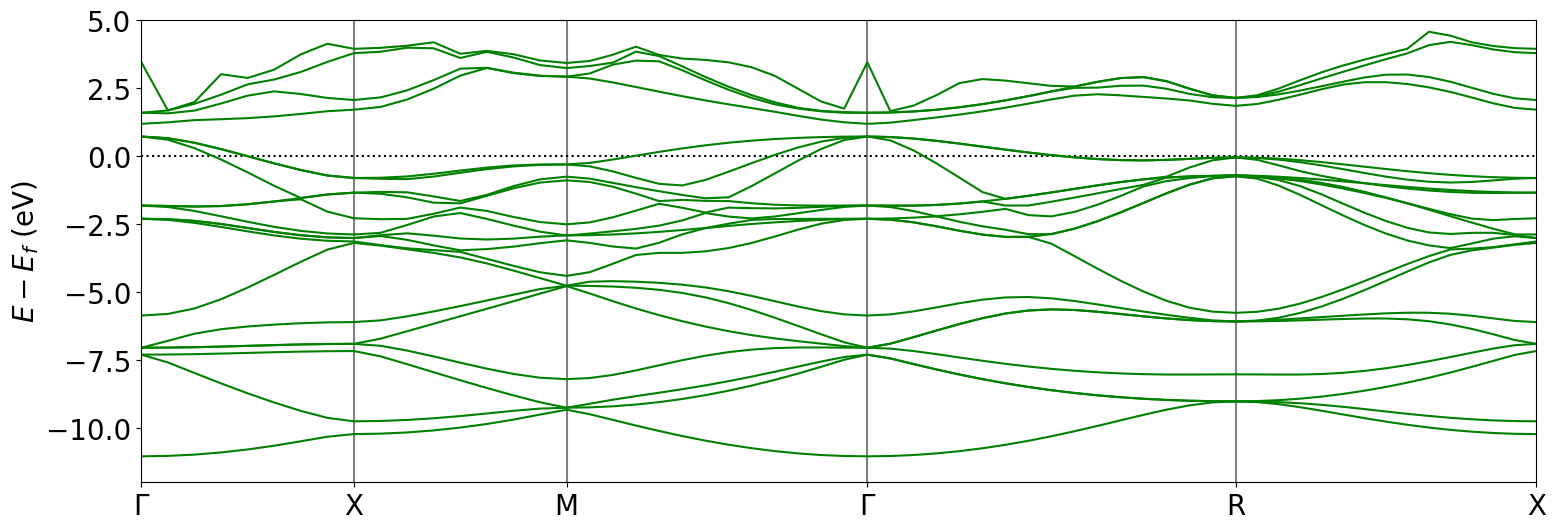

In [192]:
ax = bs_SiBDiamond.plot(emin=-12, emax=5)
ax.set_ylabel('$E-E_f$ (eV)')

(!!!) **Consulta:** ¿Cómo podría hacer para extraer el gap, así lo comparo con el de Si puro? ¿Qué puedo decir del gráfico? ¿Hay más información que pueda obtener del gráfico?